# Analysis: Live Birth Occurrence

In [1]:
library("tidyverse")
library("tidymodels")

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”Warning message:
“package ‘tidyr’ was built under R version 3.6.2”Warning message:
“package ‘dplyr’ was built under R version 3.6.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘tidymodels’ was built under R version 3.6.2”── Attaching packages ────────────────────────────────────── tidymodels 0.1.0 ──
✔ broom     0.5.5          ✔ rsample   0.0.5     
✔ dials     0.0.4          ✔ tune      0.0.1.9000
✔ infer     0.5.1          ✔ workflows 0.1.1     
✔ parsnip   0.0.5   

## Pre-processing

In [2]:
ivf_df = read_rds("birth_ivf_cleaned.rds")

In [3]:
ivf_split = ivf_df %>% initial_split(prop=0.8)

In [4]:
proc_rules <- recipe(live_birth_occurr ~ ., data=ivf_split %>% training()) %>% 
    # resample
    step_downsample(live_birth_occurr) %>%
    # transformation
    # step_bagimpute(all_predictors()) %>%
    step_other(all_nominal(), -all_outcomes()) %>%
    step_string2factor(all_nominal()) %>%
    step_dummy(all_nominal(), -all_outcomes()) %>%
    # auto trim
    step_naomit(all_predictors())
    # step_corr(all_numeric()) %>%
    # step_lincomb(all_numeric()) %>%
    # step_zv(all_numeric())
proc_rules

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         61

Operations:

Down-sampling based on live_birth_occurr
Collapsing factor levels for all_nominal, -, all_outcomes()
Factor variables from all_nominal
Dummy variables from all_nominal, -, all_outcomes()
Removing rows with NA values in all_predictors

In [5]:
proc_rules_prep = proc_rules %>% prep()
training_df = proc_rules_prep %>% juice()
testing_df = proc_rules_prep %>% bake(new_data=ivf_split %>% testing())

In [6]:
training_df %>% skimr::skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             314752    
Number of columns          115       
_______________________              
Column type frequency:               
  factor                   1         
  numeric                  114       
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable     n_missing complete_rate ordered n_unique
1 live_birth_occurr         0             1 FALSE          2
  top_counts          
1 1: 162145, 0: 152607

── Variable type: numeric ──────────────────────────────────────────────────────
    skim_variable                                                       
  1 total_number_of_live_births___conceived_through_ivf                 
  2 type_of_infertility___female_primary                                
  3 type_of_infertility___fe

In [7]:
testing_df %>% skimr::skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             170194    
Number of columns          115       
_______________________              
Column type frequency:               
  factor                   1         
  numeric                  114       
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable     n_missing complete_rate ordered n_unique top_counts         
1 live_birth_occurr         0             1 FALSE          2 0: 129491, 1: 40703

── Variable type: numeric ──────────────────────────────────────────────────────
    skim_variable                                                       
  1 cause__of_infertility___tubal_disease                               
  2 cause_of_infertility____partner_sperm_immunological_factors         
  3 cause_of_infertility____partne

## Modelling

In [8]:
model = logistic_reg(mode="classification", mixture=0, penalty=0.1) %>%
    set_engine("glmnet")
model_fit = model %>% fit(live_birth_occurr ~ ., data=training_df)
model_fit

parsnip model object

Fit time:  1m 25.5s 

Call:  glmnet::glmnet(x = as.matrix(x), y = y, family = "binomial",      alpha = ~0) 

     Df     %Dev  Lambda
1   109 0.000000 112.900
2   109 0.001225 102.900
3   109 0.001343  93.740
4   109 0.001470  85.410
5   109 0.001610  77.830
6   109 0.001762  70.910
7   109 0.001928  64.610
8   109 0.002110  58.870
9   109 0.002308  53.640
10  109 0.002523  48.880
11  109 0.002758  44.530
12  109 0.003014  40.580
13  109 0.003292  36.970
14  109 0.003594  33.690
15  109 0.003922  30.700
16  109 0.004278  27.970
17  109 0.004664  25.480
18  109 0.005082  23.220
19  109 0.005535  21.160
20  109 0.006024  19.280
21  109 0.006538  17.570
22  109 0.007106  16.000
23  109 0.007716  14.580
24  109 0.008374  13.290
25  109 0.009079  12.110
26  109 0.009836  11.030
27  109 0.010650  10.050
28  109 0.011510   9.159
29  109 0.012440   8.345
30  109 0.013430   7.604
31  109 0.014480   6.928
32  109 0.015600   6.313
33  109 0.016790   5.752
34  109 0.018040   

In [19]:
assess_df = model_fit %>% 
    predict(
        training_df
    ) %>%
    bind_cols(
        training_df
    )
assess_df = assess_df %>%
    metrics(truth=live_birth_occurr, estimate=.pred_class) %>%
    bind_rows(
        assess_df %>%
            mutate_at(vars(.pred_class), function(x) as.integer(as.character(x))) %>%
            roc_auc(., live_birth_occurr, .pred_class)
    )
assess_df

.metric,.estimator,.estimate
accuracy,binary,0.6623691
kap,binary,0.3193420
roc_auc,binary,0.6585507


# A tibble: 3 x 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.591
2 kap      binary         0.219
3 roc_auc  binary         0.658


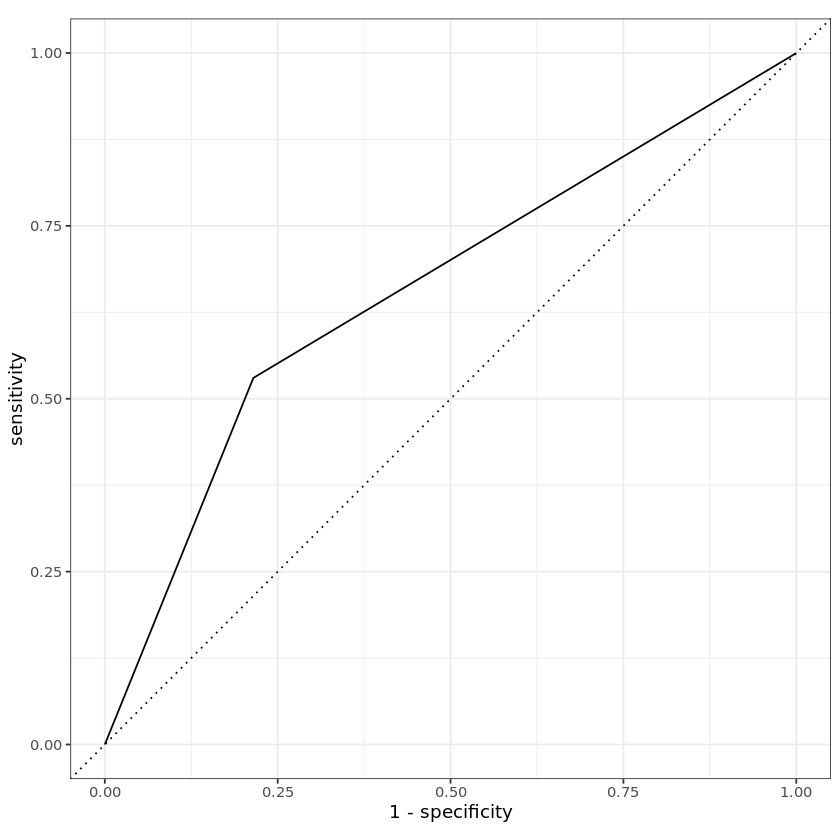

In [13]:
model_pred = model_fit %>% predict(testing_df)

pred_df = model_pred %>% bind_cols(testing_df)
pred_df %>%
    metrics(truth=live_birth_occurr, estimate=.pred_class) %>%
    bind_rows(
        pred_df %>%
            mutate_at(vars(.pred_class), function(x) as.integer(as.character(x))) %>%
            roc_auc(., live_birth_occurr, .pred_class)
    ) %>% print()

pred_df %>%
    mutate_at(vars(.pred_class), function(x) as.integer(as.character(x))) %>%
    roc_curve(., live_birth_occurr, .pred_class) %>%
    autoplot()

In [14]:
pred_df %>% write_rds("pred_df_logit.rds")

In [20]:
assess_df %>% write_rds("assess_df_logit.rds")

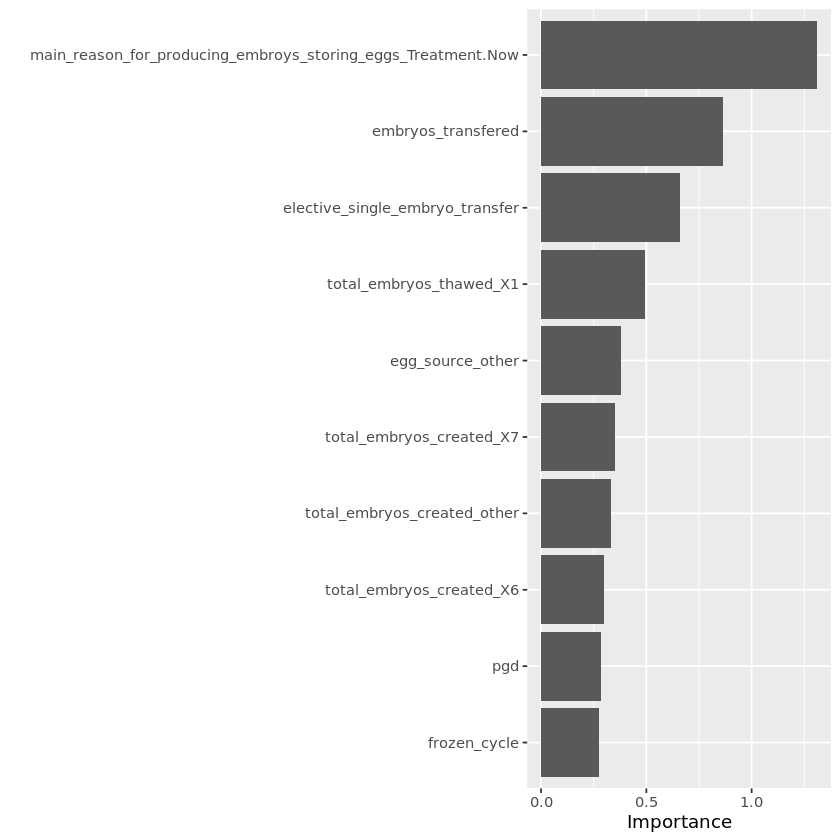

In [11]:
vip::vip(model_fit)